In [1]:
import torch, torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Dataset and dataloader operations
train_set = torchvision.datasets.MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])
test_set = torchvision.datasets.MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16384, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16384, shuffle=False)

In [3]:
#Definition of a high capacity model to be used as teacher 
class LargeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(       
          torch.nn.Linear(784, 1024),
          torch.nn.ReLU(),
          torch.nn.Dropout(p=0.5),
          torch.nn.Linear(1024, 1024),
          torch.nn.ReLU(),
          torch.nn.Dropout(p=0.5),
          torch.nn.Linear(1024, 10),
        )
    def forward(self, x):
        return self.layers(x)

In [4]:
#Definition of a lower capacity model to be used as student
class TinyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(784, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(256, 10),
        )
    def forward(self, x):
        return self.layers(x)

In [5]:
#Definitions for training and evaluation logic

def train(model, train_loader):
    '''
      Trains 'model' for one epoch of 'train_loader'
    '''

    model.train()

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters()) 
    for imgs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = imgs.cuda(), labels.cuda()
        flat_imgs = imgs.view(-1, 784)
        scores = model(flat_imgs)
        loss = loss_fn(scores, labels)
        loss.backward()
        optimizer.step()


def evaluate(model, loader):
    '''
      Evaluates 'model' accuracy on 'loader'
    '''
    model.eval()
    correct = 0
    false = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            flat_imgs = imgs.view(-1, 784)
            scores = model(flat_imgs)
            preds = torch.argmax(scores, dim=-1)
            correct_batch = torch.sum(preds==labels)
            false_batch = len(labels) - correct_batch
            correct += correct_batch.item()
            false += false_batch.item()
    return correct / (correct + false)





In [6]:
# model = LargeModel().cuda()
# model.train()
# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters())
# for imgs, labels in tqdm(train_loader):
#         optimizer.zero_grad()
#         imgs, labels = imgs.cuda(), labels.cuda()
#         flat_imgs = imgs.view(-1, 784)
#         scores = model(flat_imgs)
#         print(sum(scores[4]))
#         prob = torch.nn.functional.softmax(scores, dim=-1)
#         print(sum(prob[4]))
#         break

# Section 1
## Train a teacher network for 10 epochs.

In [7]:
#Train teacher standalone
#You should change the cell to include plotting logic

teacher = LargeModel().cuda()
val_accs = []
epochs = []
for epoch in range(10):
    val_acc = evaluate(teacher, val_loader)
    print(f'\nValidation accuracy before epoch {epoch+1}: {val_acc}')
    train(teacher, train_loader)
    val_acc_after = evaluate(teacher, val_loader)
    val_accs.append(val_acc_after)
    epochs.append(epoch+1)
    # print(f'\nValidation accuracy after epoch {epoch+1}: {val_acc_after}')
    
test_acc = evaluate(teacher, test_loader)
print(f'\nTest accuracy after {epoch+1} epochs of training: {test_acc}')





Validation accuracy before epoch 1: 0.0984


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.51it/s]



Validation accuracy before epoch 2: 0.9225


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.59it/s]



Validation accuracy before epoch 3: 0.9541


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.50it/s]



Validation accuracy before epoch 4: 0.9637


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.52it/s]



Validation accuracy before epoch 5: 0.9687


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.65it/s]



Validation accuracy before epoch 6: 0.9731


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.85it/s]



Validation accuracy before epoch 7: 0.9755


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.85it/s]



Validation accuracy before epoch 8: 0.9765


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.79it/s]



Validation accuracy before epoch 9: 0.9773


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.65it/s]



Validation accuracy before epoch 10: 0.9777


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.46it/s]



Test accuracy after 10 epochs of training: 0.9813


## Report the best validation

In [8]:
max(val_accs)

0.9797

## Report test accuracy  

In [9]:
test_acc

0.9813

## Plot the validation accuracy with respect to training epoch.

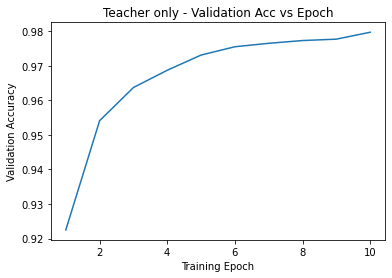

In [10]:
plt.plot(epochs, val_accs)
plt.xlabel('Training Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Teacher only - Validation Acc vs Epoch')
# plt.legend()
plt.show()

# Section 2
## Train a student network for 10 epochs.

In [11]:
#Train student standalone
#You should change the cell to include plotting logic

student = TinyModel().cuda()
val_accs = []
epochs = []
for epoch in range(10):
    val_acc = evaluate(student, val_loader)
    print(f'\nValidation accuracy before epoch {epoch+1}: {val_acc}')
    train(student, train_loader)
    val_acc_after = evaluate(student, val_loader)
    val_accs.append(val_acc_after)
    epochs.append(epoch+1)
test_acc = evaluate(student, test_loader)
print(f'\nTest accuracy after {epoch+1} epochs of training: {test_acc}')




Validation accuracy before epoch 1: 0.0887


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.67it/s]



Validation accuracy before epoch 2: 0.8862


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.63it/s]



Validation accuracy before epoch 3: 0.9156


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.58it/s]



Validation accuracy before epoch 4: 0.9299


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.46it/s]



Validation accuracy before epoch 5: 0.94


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.57it/s]



Validation accuracy before epoch 6: 0.9478


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.87it/s]



Validation accuracy before epoch 7: 0.9514


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.89it/s]



Validation accuracy before epoch 8: 0.9562


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.91it/s]



Validation accuracy before epoch 9: 0.9603


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.51it/s]



Validation accuracy before epoch 10: 0.963


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.39it/s]



Test accuracy after 10 epochs of training: 0.9677


## Report the best validation

In [12]:
student_only = val_accs.copy()
max(val_accs)


0.9647

## Report test accuracy

In [13]:
test_acc

0.9677

## Plot the validation accuracy with respect to training epoch.

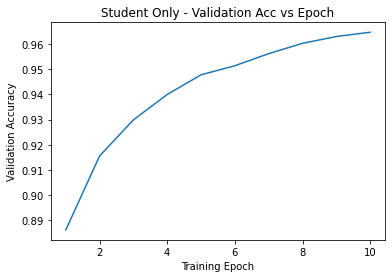

In [14]:
plt.plot(epochs, val_accs)
plt.xlabel('Training Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Student Only - Validation Acc vs Epoch')
plt.show()

# Section 3
##  Distill the knowledge of the teacher model into the student. Use MSE loss for teacher-student probability matching.


### Sources


In [15]:
# Define distillation logic as a function
# You should change this cell to complete the function

def distill(teacher, student, train_loader, temperature):
    '''
      Distills 'teacher' knowledge into 'student' for an epoch 
      using 'train_loader' and 'temperature'
    '''

    # Set teacher to the proper mode (train or eval)
    teacher.eval()
     
    # Set student to the proper mode (train or eval)
    student.train()
     

    ce_loss_fn = torch.nn.CrossEntropyLoss()

    # Define loss function for distillation
    distill_loss_fn = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(student.parameters()) 
    
    for imgs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = imgs.cuda(), labels.cuda()
        flat_imgs = imgs.view(-1, 784)
        student_scores = student(flat_imgs)
        teacher_scores = teacher(flat_imgs)

        # Compute output probabilities of teacher and student using
        # the scores and temperature constant
        student_probs = torch.nn.functional.softmax(student_scores/temperature, dim=-1)
        teacher_probs = torch.nn.functional.softmax(teacher_scores/temperature, dim=-1)

        ce_loss = ce_loss_fn(student_scores, labels)
        distill_loss = distill_loss_fn(student_probs, teacher_probs)

        loss = ce_loss + distill_loss

        loss.backward()
        optimizer.step()

## Experiment with temperature constant, number of epochs.
**NOTE:** There is no learning process on the teacher object. Therefore, we do not expect any difference in test accuracy before and after the distillation process.

In [16]:
# Distill trained teacher knowledge into student
# Make sure student is freshly initialized and 
# teacher is trained before distillation

test_acc_per_temp = []
test_temperature = [1, 2.5, 5, 10, 20]
results = {}
results['Epoch'] = epochs
for temp in test_temperature:
    """Initialization"""
    # To make sure the student is freshly initialized, I delete the object and create again.
    del student
    student = TinyModel().cuda()
    # The teacher object trained in the cells above will be used.
    test_acc = evaluate(teacher, test_loader)
    print(f'\nTest accuracy of teacher before distillation: {test_acc}')
    
    """Distillation"""
    results[temp] = []
    for epoch in range(10):
        val_acc = evaluate(student, val_loader)
        print(f'\nValidation accuracy before epoch {epoch+1}: {val_acc}')
        distill(teacher, student, train_loader, temperature=temp)
        val_acc_after = evaluate(student, val_loader)
        results[temp].append(val_acc_after)

    test_acc = evaluate(student, test_loader)
    test_acc_per_temp.append(test_acc)
    print(f'\nTest accuracy after {epoch+1} epochs of distillation: {test_acc}')


Test accuracy of teacher before distillation: 0.9813

Validation accuracy before epoch 1: 0.0561


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.02it/s]



Validation accuracy before epoch 2: 0.8824


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.11it/s]



Validation accuracy before epoch 3: 0.9185


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.14it/s]



Validation accuracy before epoch 4: 0.9319


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 10.74it/s]



Validation accuracy before epoch 5: 0.941


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.29it/s]



Validation accuracy before epoch 6: 0.9465


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.01it/s]



Validation accuracy before epoch 7: 0.9511


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.31it/s]



Validation accuracy before epoch 8: 0.9564


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.54it/s]



Validation accuracy before epoch 9: 0.9607


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.57it/s]



Validation accuracy before epoch 10: 0.9617


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.79it/s]



Test accuracy after 10 epochs of distillation: 0.9663

Test accuracy of teacher before distillation: 0.9813

Validation accuracy before epoch 1: 0.1024


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.57it/s]



Validation accuracy before epoch 2: 0.8875


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.68it/s]



Validation accuracy before epoch 3: 0.9155


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.64it/s]



Validation accuracy before epoch 4: 0.9331


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.53it/s]



Validation accuracy before epoch 5: 0.9414


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.55it/s]



Validation accuracy before epoch 6: 0.9492


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.62it/s]



Validation accuracy before epoch 7: 0.9532


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.77it/s]



Validation accuracy before epoch 8: 0.9553


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.62it/s]



Validation accuracy before epoch 9: 0.959


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.57it/s]



Validation accuracy before epoch 10: 0.9619


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.59it/s]



Test accuracy after 10 epochs of distillation: 0.967

Test accuracy of teacher before distillation: 0.9813

Validation accuracy before epoch 1: 0.0723


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.10it/s]



Validation accuracy before epoch 2: 0.8847


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.45it/s]



Validation accuracy before epoch 3: 0.9182


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.66it/s]



Validation accuracy before epoch 4: 0.9304


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.89it/s]



Validation accuracy before epoch 5: 0.9396


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 12.03it/s]



Validation accuracy before epoch 6: 0.9461


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.55it/s]



Validation accuracy before epoch 7: 0.9504


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.74it/s]



Validation accuracy before epoch 8: 0.9539


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.74it/s]



Validation accuracy before epoch 9: 0.9588


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.67it/s]



Validation accuracy before epoch 10: 0.9616


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.54it/s]



Test accuracy after 10 epochs of distillation: 0.9665

Test accuracy of teacher before distillation: 0.9813

Validation accuracy before epoch 1: 0.0955


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.22it/s]



Validation accuracy before epoch 2: 0.8886


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.58it/s]



Validation accuracy before epoch 3: 0.9177


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.32it/s]



Validation accuracy before epoch 4: 0.9321


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.14it/s]



Validation accuracy before epoch 5: 0.9428


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.56it/s]



Validation accuracy before epoch 6: 0.9482


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.42it/s]



Validation accuracy before epoch 7: 0.9531


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.78it/s]



Validation accuracy before epoch 8: 0.958


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.54it/s]



Validation accuracy before epoch 9: 0.9608


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.21it/s]



Validation accuracy before epoch 10: 0.9639


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.81it/s]



Test accuracy after 10 epochs of distillation: 0.9678

Test accuracy of teacher before distillation: 0.9813

Validation accuracy before epoch 1: 0.0765


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.22it/s]



Validation accuracy before epoch 2: 0.8867


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.56it/s]



Validation accuracy before epoch 3: 0.9167


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.67it/s]



Validation accuracy before epoch 4: 0.9323


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.65it/s]



Validation accuracy before epoch 5: 0.9407


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.19it/s]



Validation accuracy before epoch 6: 0.9487


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.50it/s]



Validation accuracy before epoch 7: 0.954


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.66it/s]



Validation accuracy before epoch 8: 0.9579


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.68it/s]



Validation accuracy before epoch 9: 0.9599


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.78it/s]



Validation accuracy before epoch 10: 0.9632


100%|███████████████████████████████████████████| 49/49 [00:04<00:00, 11.40it/s]



Test accuracy after 10 epochs of distillation: 0.9671


## Report the temperature that obtains best distillation test accuracy

In [17]:
df_test = pd.DataFrame({'Test Accuracy': test_acc_per_temp}, index = test_temperature)
df_test = df_test.style.highlight_max(color = 'lightgreen', axis = 0)
df_test

The best distillation accuracy obtained with Tempereture 10

In [18]:
best_temperature = 10

## Report the best validation obtained by distillation

In [19]:
df = pd.DataFrame.from_dict(results,orient='columns' ).set_index('Epoch')
df_best_val_epoch = df.style.highlight_max(color = 'lightgreen', axis = 0)
display(df_best_val_epoch)

Best validation for each temperature value is obtained in the last epoch and the values are highligted in the table.

## Report test accuracy obtained by distillation

As we higlighted two cells above, the best test accuracy is 0.968400 with Temperature 10

## Plot the validation accuracy with respect to training epoch

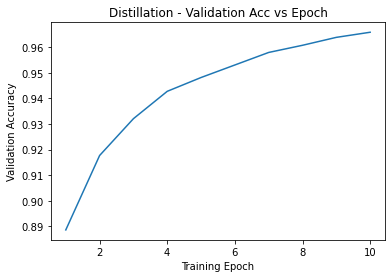

In [20]:
plt.plot(epochs, results[best_temperature])
plt.xlabel('Training Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Distillation - Validation Acc vs Epoch')
plt.show()

# Section 4
## Plot the validation accuracy for distillation with the best temperature constant and standalone training of the student

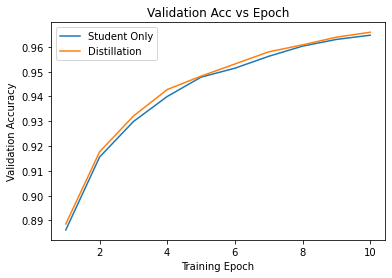

In [21]:
plt.plot(epochs, student_only, label = 'Student Only')
plt.plot(epochs, results[best_temperature], label = 'Distillation')
plt.xlabel('Training Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Acc vs Epoch')
plt.legend()
plt.show()

## Discuss


In the 'Distilling the Knowledge in a Neural Network' paper, there is a statement that "... the small model can often be trained on much less data than the original cumbersome model and using a much higher learning rate". We can highlight the statement with the limited epoch that the model trained without distillation tends to fluctuate while training. On the other hand, the distillation method tells the smaller model more decisively in which direction it should proceed in training. 